# Self-Improving RAG Agent

## Overview

Traditional RAG systems have a critical limitation: they retrieve documents once and then generate an answer based on those documents, regardless of their relevance. An agentic approach allows the system to adapt its retrieval strategy based on objective performance metrics.

This notebook provides a framework for evaluating agentic RAG systems.

## Setup

First, let's install the necessary libraries:

In [67]:
%pip install openai chromadb sentence_transformers pandas matplotlib numpy tqdm

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [76]:
import openai
import chromadb
from chromadb.utils import embedding_functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import getpass
from tqdm import tqdm
from sentence_transformers import CrossEncoder
from typing import Optional, List, Dict, Type

# Display settings for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)

# Define paths
DATA_DIR = "../data/papers"
EVAL_DIR = "../data/evalset"

# Initialize OpenAI and Chroma
openai.api_key = getpass.getpass('Enter your OpenAI API key: ')
chroma_client = chromadb.PersistentClient()

# Global variables
K_VALUES = [1, 3, 5, 10]

### Loading Evaluation Dataset

Let's load the eval set we created previously:

In [77]:
eval_df = pd.read_json('../data/evalset/evalset.json')
print(f"Loaded {len(eval_df)} evaluation examples")
print(eval_df.head())

Loaded 209 evaluation examples
                  id                                                                                             document                                                                                                query                                                                                               answer
0  gpt_1.pdf_chunk_0  Improving Language Understanding\nby Generative Pre-Training\nAlec Radford\nOpenAI\nalec@openai....  describe the process of generative pre-training and its impact on language understanding tasks i...  The process of generative pre-training involves training a language model on a diverse corpus of...
1  gpt_1.pdf_chunk_1  speciﬁc task. In contrast to previous approaches, we make use of task-aware input\ntransformatio...                           key findings and performance metrics on evaluated benchmarks in this paper  The key findings indicate that the approach significantly improves upon the state of the art in .

### Let's build our Agent

In [81]:
class RAGAgent:
    def __init__(self, collection, llm_model: str = "gpt-3.5-turbo", embedding_model: str = "text-embedding-3-small", reranker_model: Optional[str] = None):
        self.collection = collection
        self.llm_model = llm_model
        self.embedding_model = embedding_model
        self.reranker_model = reranker_model
        self.max_iterations = 3
        self.target_metrics = {"recall": 0.8, "mrr": 0.5}
        self.top_k = 10
        self.agent_type = self.__class__.__name__

    def retrieve(self, query: str):
        results = self.collection.query(query_texts=[query], n_results=self.top_k)
        results = {"ids": results['ids'][0], "documents": results['documents'][0]}

        if self.reranker_model:
            cross_encoder = CrossEncoder(self.reranker_model)
            pairs = [(query, doc) for doc in results["documents"]]
            scores = cross_encoder.predict(pairs)
            reranked_indices = np.argsort(-scores)[:self.top_k]
            return {
                "ids": [results["ids"][i] for i in reranked_indices],
                "documents": [results["documents"][i] for i in reranked_indices]
            }

        return results
    
    def evaluate_retrieval(self, predictions: List[str], ground_truth: List[str]):
        metrics = {}

        def calculate_mrr(predictions: list[str], ground_truth: list[str]):
            mrr = 0
            for label in ground_truth:
                if label in predictions:
                    mrr = max(mrr, 1 / (predictions.index(label) + 1))
            return mrr
        
        def calculate_recall(predictions: list[str], ground_truth: list[str]):
            return len([label for label in ground_truth if label in predictions]) / len(ground_truth)
        
        for k in K_VALUES:
            metrics[f"mrr@{k}"] = calculate_mrr(predictions[:k], ground_truth)
            metrics[f"recall@{k}"] = calculate_recall(predictions[:k], ground_truth)

        return metrics
    
    def rewrite_query(self, query: str, retrieved_docs: List[str]):
        system_prompt = "You are an assistant that refines search queries to be precise and targeted for optimal document retrieval."
        user_message = f"Original query: {query}\n\n"
    
        if retrieved_docs:
            user_message += f"The following documents were retrieved but did not achieve good retrieval metrics:\n\n"
            for i, doc in enumerate(retrieved_docs[:3]):
                user_message += f"Document {i+1}:\n{doc}\n\n"
        user_message += f"Please rewrite the query to be more specific and targeted to improve retrieval performance. Return ONLY the reformulated query without any explanations or additional text."
    
        response = openai.chat.completions.create(
            model=self.llm_model,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_message}
            ]
        )
    
        return response.choices[0].message.content.strip()    

    def generate_answer(self, query: str, documents: List[str]):
        context = "\n\n".join(documents)
        response = openai.chat.completions.create(
            model=self.llm_model,
            messages=[
                {"role": "system", "content": "You are an assistant that answers questions based on the provided context."},
                {"role": "user", "content": f"Context:\n{context}\n\nQuestion: {query}\n\nAnswer the question based on the context provided. If the context doesn't contain the answer, say 'I don't have enough information to answer this question.'"}
            ]
        )
        return response.choices[0].message.content
    
    def _is_target_achieved(self, metrics: Dict[str, float]) -> bool:
        recall_key = f"recall@{self.top_k}"
        mrr_key = f"mrr@{self.top_k}"
        
        current_recall = metrics.get(recall_key, 0)
        current_mrr = metrics.get(mrr_key, 0)
        
        target_recall = self.target_metrics.get("recall", 0)
        target_mrr = self.target_metrics.get("mrr", 0)

        return current_recall >= target_recall and current_mrr >= target_mrr
    
    def run(self, query: str, ground_truth: List[str] = None):
        current_query = query
        iteration = 0
        best_metrics = {"recall@10": 0, "mrr@10": 0}
        best_retrieval = None

        for iteration in range(1, self.max_iterations + 1):
            # Retrieve documents and evaluate
            retrievals = self.retrieve(current_query)
            documents, predictions = retrievals["documents"], retrievals['ids']
            metrics = self.evaluate_retrieval(predictions, ground_truth) if ground_truth else {}

            # Check if this is the best retrieval so far
            if ground_truth:
                recall_key, mrr_key = f"recall@{self.top_k}", f"mrr@{self.top_k}"
                if (metrics.get(recall_key, 0), metrics.get(mrr_key, 0)) >= (best_metrics.get(recall_key, 0), best_metrics.get(mrr_key, 0)):
                    best_metrics = metrics
                    best_retrieval = {"documents": documents, "predictions": predictions, "query": current_query}
            else:
                # Without ground truth, just use the latest retrieval
                best_retrieval = {"documents": documents, "predictions": predictions, "query": current_query}

            # Check if we've met our targets or reached max iterations
            if not ground_truth or self._is_target_achieved(metrics) or iteration == self.max_iterations:
                final_docs = best_retrieval["documents"] if best_retrieval else documents
                final_query = best_retrieval["query"] if best_retrieval else current_query
                answer = self.generate_answer(query, final_docs)
                return {
                    "query": query,
                    "final_query": final_query,
                    "answer": answer,
                    "iterations": iteration,
                    "metrics": best_metrics,
                    "success": True if not ground_truth or self._is_target_achieved(metrics) else False
                }
                
            # Rewrite query and try again
            current_query = self.rewrite_query(query, documents[:3])
            print(f"Reformulated query: {current_query}")

In [82]:
class RAGEvaluator:
    def __init__(self, chroma_client):
        self.chroma_client = chroma_client
        self.collections = {}
    
    def create_collection(self, collection_name: str, evalset: pd.DataFrame, embedding_model: str):
        cache_key = f"{collection_name}_{embedding_model}"
        if cache_key in self.collections:
            return self.collections[cache_key]
        
        print(f"Initializing collection {collection_name}")

        # Initialize embedding function
        embedding_function = embedding_functions.OpenAIEmbeddingFunction(model_name=embedding_model, api_key=openai.api_key)
        #embedding_function = embedding_functions.SentenceTransformerEmbeddingFunction(model_name="all-mpnet-base-v2")
        
        # Delete collection if it exists
        try:
            self.chroma_client.delete_collection(name=collection_name)
            print(f"Deleted existing collection {collection_name}")
        except:
            print(f"No existing collection {collection_name} to delete")
        
        # Create new collection
        collection = self.chroma_client.create_collection(name=collection_name, embedding_function=embedding_function)

        # Add documents to collection
        for _, row in evalset.iterrows():
            collection.upsert(
                documents=[row['document']],
                ids=[row['id']],
                metadatas=[{'id': row['id'], 'query': row['query'], 'answer': row['answer']}]
            )
        
        print(f"Created collection {collection_name} with {collection.count()} documents using {embedding_model}")

        # Cache collection
        self.collections[cache_key] = collection
        return collection
    
    def create_agent_config(self, agent_class: Type[RAGAgent], embedding_model: str, reranker_model: Optional[str] = None, **agent_params):
        return {
            'agent_class': agent_class,
            'embedding_model': embedding_model,
            'reranker_model': reranker_model,
            'params': agent_params
        }
    
    def evaluate_configurations(self, eval_df: pd.DataFrame, configurations: List[Dict[str, Any]]):
        all_results = []
        
        # Evaluate each configuration
        for config in configurations:
            agent_class = config['agent_class']
            embedding_model = config['embedding_model']
            reranker_model = config['reranker_model']
            agent_params = config['params']
            
            # Create a descriptive name
            config_name = f"{agent_class.__name__}-{embedding_model}-{reranker_model}" if reranker_model else f"{agent_class.__name__}-{embedding_model}"
            print(f"\nEvaluating configuration: {config_name}")
            
            # Create collection for this embedding model
            collection_name = f"eval_{embedding_model.replace('-', '_')}"
            collection = self.create_collection(collection_name, eval_df, embedding_model)
            
            # Create agent with this collection
            agent = agent_class(collection=collection, reranker_model=reranker_model, **agent_params)
            
            # Run evaluation on this agent
            results = []
            for idx, row in tqdm(eval_df.iterrows(), total=len(eval_df), desc=f"Testing {config_name}"):
                query = row['query']
                ground_truth = [row['id']]
                
                # Run the query with this agent
                result = agent.run(query, ground_truth)
                
                # Get the final metrics
                final_metrics = result.get('metrics', {})
                
                # Record results for each k value
                for k in K_VALUES:
                    for metric_name, metric_key in [('recall', f'recall@{k}'), ('mrr', f'mrr@{k}')]:
                        if metric_key in final_metrics:
                            results.append({
                                'query_id': idx,
                                'config_name': config_name,
                                'agent_type': agent.agent_type,
                                'embedding_model': embedding_model,
                                'reranker_model': str(reranker_model),
                                'k': k,
                                'metric': metric_name,
                                'score': final_metrics[metric_key],
                                'iterations': result.get('iterations', 1)
                            })
            
            all_results.extend(results)
        
        # Combine all results
        evaluation_df = pd.DataFrame(all_results)
        print(f"Evaluation complete with {len(evaluation_df)} data points")
        
        return evaluation_df
    
    def visualize_results(self, results_df: pd.DataFrame):
        # Calculate average scores by configuration and k value
        avg_results = results_df.groupby(['config_name', 'embedding_model', 'reranker_model', 'k', 'metric'])['score'].mean().reset_index()
        
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
        
        # Plot recall for different configurations
        recall_data = avg_results[avg_results['metric'] == 'recall']
        for config in recall_data['config_name'].unique():
            data = recall_data[recall_data['config_name'] == config]
            ax1.plot(data['k'], data['score'], marker='o', label=config)
        
        ax1.set_title("Recall@k for Different Configurations")
        ax1.set_xlabel("k")
        ax1.set_ylabel("Recall")
        ax1.grid(True)
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Plot MRR for different configurations
        mrr_data = avg_results[avg_results['metric'] == 'mrr']
        for config in mrr_data['config_name'].unique():
            data = mrr_data[mrr_data['config_name'] == config]
            ax2.plot(data['k'], data['score'], marker='o', label=config)
        
        ax2.set_title("MRR@k for Different Configurations")
        ax2.set_xlabel("k")
        ax2.set_ylabel("MRR")
        ax2.grid(True)
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.savefig('configuration_comparison.png')
        plt.show()
        
        # First, deduplicate to get one row per query and configuration
        unique_iterations = results_df.drop_duplicates(['query_id', 'embedding_model', 'reranker_model'])
        # Then group by embedding model and reranker
        iterations_by_config = unique_iterations.groupby(['embedding_model', 'reranker_model'])['iterations'].mean().reset_index()
        
        # Create a bar chart
        plt.figure(figsize=(14, 6))
        bars = plt.bar(
            range(len(iterations_by_config)), 
            iterations_by_config['iterations'],
            color='skyblue'
        )
        
        # Add labels
        plt.xticks(
            range(len(iterations_by_config)), 
            [f"{row['embedding_model']}-{row['reranker_model']}" for _, row in iterations_by_config.iterrows()],
            rotation=45,
            ha='right'
        )
        plt.title("Average Iterations Needed by Configuration")
        plt.xlabel("Configuration")
        plt.ylabel("Average Iterations")
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Add value labels on top of bars
        for i, bar in enumerate(bars):
            plt.text(
                bar.get_x() + bar.get_width()/2,
                bar.get_height() + 0.05,
                f"{bar.get_height():.2f}",
            ha='center'
        )
    
        plt.tight_layout()
        plt.savefig('iterations_by_config.png')
        plt.show()


Evaluating configuration: RAGAgent-text-embedding-3-small
Initializing collection eval_text_embedding_3_small
Deleted existing collection eval_text_embedding_3_small
Created collection eval_text_embedding_3_small with 209 documents using text-embedding-3-small


Testing RAGAgent-text-embedding-3-small:   0%|          | 1/209 [00:06<24:04,  6.94s/it]

Reformulated query: Precise query refinement: Identify key findings and performance metrics related to zero-shot, one-shot, and few-shot evaluations in the analyzed benchmarks of the paper.
Reformulated query: key findings and performance metrics of zero-shot, one-shot, and few-shot evaluations in language models


Testing RAGAgent-text-embedding-3-small:   2%|▏         | 4/209 [00:16<11:26,  3.35s/it]

Reformulated query: Refined query: Explain the two-stage training procedure outlined in Figure 2 of the InstructGPT paper.
Reformulated query: Refined query: Explain the two-stage training procedure depicted in Figure 2 of the InstructGPT paper.


Testing RAGAgent-text-embedding-3-small:   2%|▏         | 5/209 [00:19<11:18,  3.32s/it]

Reformulated query: Refined query: Provide examples and effectiveness of task-aware input transformations used for fine-tuning in achieving transfer learning advancements.
Reformulated query: Role of task-specific input adaptations in the proposed model utilizing traversal-style input transformations for effective transfer learning.


Testing RAGAgent-text-embedding-3-small:   3%|▎         | 6/209 [00:25<13:43,  4.06s/it]

Reformulated query: Performance improvements of the model on tasks analyzed in Table 5 of the paper.
Reformulated query: Performance improvements of the finetuned Transformer LM model on various tasks compared to other models in the paper.


Testing RAGAgent-text-embedding-3-small:   8%|▊         | 16/209 [00:52<09:21,  2.91s/it]

Reformulated query: Refined query: Compare the performance of the proposed model on traditional language modeling tasks, Cloze tasks, sentence/paragraph completion tasks, and closed book question answering tasks across various datasets mentioned in the evaluation.
Reformulated query: Refined query: Evaluate the performance of the proposed model on traditional language modeling tasks, "closed book" question answering tasks, and language translation tasks across various datasets.


Testing RAGAgent-text-embedding-3-small:   9%|▊         | 18/209 [00:59<10:16,  3.23s/it]

Reformulated query: Retrieve performance comparison results of the Finetuned Transformer LM on the RACE dataset against other models with a focus on accuracy metrics.
Reformulated query: Retrieve performance comparison of Finetuned Transformer LM with other models specifically on the RACE dataset.


Testing RAGAgent-text-embedding-3-small:  12%|█▏        | 25/209 [01:15<07:02,  2.30s/it]

Reformulated query: Refined query: performance improvement of the model on question answering tasks and text classification tasks compared to discriminatively trained task-specific models
Reformulated query: Refined query: effectiveness of task-aware input transformations and fine-tuning for improving model performance on question answering and text classification tasks


Testing RAGAgent-text-embedding-3-small:  13%|█▎        | 27/209 [01:23<08:49,  2.91s/it]

Reformulated query: Revised query: "performance of GPT-3 on CoQA dataset compared to baseline systems"
Reformulated query: Performance of GPT-3 language model on CoQA dataset compared to baseline systems.


Testing RAGAgent-text-embedding-3-small:  14%|█▍        | 30/209 [01:41<16:21,  5.48s/it]

Reformulated query: Refined query: Describe the two-stage training procedure of combining unsupervised pre-training with supervised fine-tuning in the Transformer model architecture as presented in the paper.
Reformulated query: Methodology of combining unsupervised pre-training and supervised fine-tuning in the paper on language understanding tasks.


Testing RAGAgent-text-embedding-3-small:  19%|█▉        | 40/209 [02:10<05:58,  2.12s/it]

Reformulated query: "Winograd Schema Challenge results GPT-3 performance evaluation"
Reformulated query: Winograd Schema Challenge results GPT-3 performance on original Winograd schemas and Winogrande dataset.


Testing RAGAgent-text-embedding-3-small:  22%|██▏       | 47/209 [02:27<06:13,  2.31s/it]

Reformulated query: Refined query: Examine the model performance trends in the paper compared to Jozefowicz et al. (2016) and Hestness et al. (2017) with a focus on fine-tuned systems and scaling without fine-tuning.
Reformulated query: Revised query: Compare the model performance trends in the paper with those reported by Jozefowicz et al. (2016) and Hestness et al. (2017) specifically in terms of benchmark tasks, scalability trends, and advancements in natural language processing methods.


Testing RAGAgent-text-embedding-3-small:  23%|██▎       | 48/209 [02:32<07:38,  2.84s/it]

Reformulated query: Revised query: GPT-2's performance comparison on language modeling datasets and ability to model long-range dependencies.
Reformulated query: Reformulated query: GPT-2's performance evaluations specifically on language modeling datasets like CBT and LAMBADA.


Testing RAGAgent-text-embedding-3-small:  24%|██▍       | 51/209 [02:41<07:36,  2.89s/it]

Reformulated query: Revised query: comparative analysis of GPT-3 and fine-tuned models in few-shot learning performance on natural language inference tasks and reading comprehension datasets
Reformulated query: Key findings on the few-shot performance of GPT-3 compared to fine-tuned models in natural language inference tasks and reading comprehension datasets


Testing RAGAgent-text-embedding-3-small:  27%|██▋       | 56/209 [02:55<06:43,  2.64s/it]

Reformulated query: GPT-3 in-context learning evaluation methodology spectrum task-speciﬁc data reliance spectrum Illustration Figure 2.1
Reformulated query: Refined query: detailed evaluation methodology for GPT-3's in-context learning abilities with a focus on different settings, such as fine-tuning, few-shot learning, one-shot learning, and zero-shot learning.


Testing RAGAgent-text-embedding-3-small:  27%|██▋       | 57/209 [03:00<08:24,  3.32s/it]

Reformulated query: Differences between few-shot, one-shot, and zero-shot learning in the context of language models as detailed in research papers.
Reformulated query: Differences between zero-shot, one-shot, and few-shot learning in language models.


Testing RAGAgent-text-embedding-3-small:  29%|██▉       | 61/209 [03:13<07:25,  3.01s/it]

Reformulated query: "Analysis of biases related to gender, race, and religion in GPT-3 and societal impacts"
Reformulated query: bias analysis of gender, race, and religion in GPT-3


Testing RAGAgent-text-embedding-3-small:  30%|██▉       | 62/209 [03:18<09:13,  3.77s/it]

Reformulated query: Refined query: Identify and describe the specific in-context learning settings evaluated in this paper.
Reformulated query: Settings for in-context learning evaluated in this paper.


Testing RAGAgent-text-embedding-3-small:  33%|███▎      | 69/209 [03:40<07:08,  3.06s/it]

Reformulated query: architectural parameters impact on computational efficiency in transformer models with a focus on model size and validation loss scaling trend
Reformulated query: architectural parameters impact on computational efficiency in transformer models


Testing RAGAgent-text-embedding-3-small:  34%|███▍      | 72/209 [03:51<07:49,  3.43s/it]

Reformulated query: Refined query: detailed description of the evaluation methodology for few-shot learning as applied to language models in the highlighted paper
Reformulated query: Refined query: elucidate the specific evaluation methodology for few-shot learning as detailed in the paper by Tom B. Brown et al. on language models.


Testing RAGAgent-text-embedding-3-small:  36%|███▌      | 75/209 [04:00<06:29,  2.91s/it]

Reformulated query: Evaluate the methodology employed to assess GPT-3's language modeling capabilities comprehensively.
Reformulated query: Refined query: detailed procedure for evaluating GPT-3's language modeling performance


Testing RAGAgent-text-embedding-3-small:  39%|███▉      | 82/209 [04:54<15:42,  7.42s/it]

Reformulated query: Query refinement: "compare performance results between zero-shot, one-shot, and few-shot settings in language model training, focusing on their impact on model sample efficiency and benchmark performance"
Reformulated query: Compare the performance differences between zero-shot, one-shot, and few-shot settings specifically in the context of in-context learning abilities and trade-offs in sample efficiency on NLP benchmarks.


Testing RAGAgent-text-embedding-3-small:  43%|████▎     | 89/209 [05:14<05:47,  2.89s/it]

Reformulated query: Effectiveness comparison of GPT-3's performance in one-shot vs few-shot settings across specific tasks
Reformulated query: Query refinement: Evaluate GPT-3's performance in the few-shot setting specifically for natural language inference tasks like ANLI, and reading comprehension tasks such as RACE or QuAC.


Testing RAGAgent-text-embedding-3-small:  48%|████▊     | 101/209 [06:07<12:41,  7.05s/it]

Reformulated query: Refined query: Examine the mean human detection accuracy of intentionally bad articles generated by GPT-3 175B model compared to a control model for news articles around 500 words long.
Reformulated query: Query refinement: compare human detection accuracy of GPT-3 versus control model articles in detecting intentionally bad news articles.


Testing RAGAgent-text-embedding-3-small:  59%|█████▉    | 124/209 [07:09<03:04,  2.18s/it]

Reformulated query: Query refinement: "Comparison of model sizes and performance in natural language processing research papers using GPT-3 and its variants"
Reformulated query: Comparative evaluation of GPT-3 model sizes and performance on specific NLP tasks across multiple research papers.


Testing RAGAgent-text-embedding-3-small:  61%|██████    | 127/209 [07:18<03:23,  2.49s/it]

Reformulated query: Differences between zero-shot, one-shot, and few-shot learning for language models in the context of performance trade-offs and sample efficiency.
Reformulated query: Compare the trade-offs, advantages, and disadvantages of zero-shot, one-shot, and few-shot learning approaches for language models.


Testing RAGAgent-text-embedding-3-small:  64%|██████▎   | 133/209 [07:34<02:54,  2.29s/it]

Reformulated query: Refined query: methodology used for dataset filtering to reduce size and its specific impact on the dataset size in a machine learning research study
Reformulated query: "impact of dataset filtering process on size reduction effectiveness"


Testing RAGAgent-text-embedding-3-small:  66%|██████▌   | 137/209 [07:45<03:00,  2.51s/it]

Reformulated query: Query refinement: demographic information of participants (age, gender distribution) in experiments evaluating human detection of model-generated news articles
Reformulated query: Participant demographics distribution (gender ratio, mean age) in experiments on human ability to distinguish model-generated news articles from real news articles.


Testing RAGAgent-text-embedding-3-small:  68%|██████▊   | 143/209 [07:59<02:16,  2.07s/it]

Reformulated query: Refined query: Evaluate and compare model performance in zero-shot, one-shot, and few-shot settings for specific language tasks.
Reformulated query: Refined query: detailed comparison of model performance on translation, Winograd Schema-like tasks, commonsense reasoning, question answering, reading comprehension, SuperGLUE benchmark suite, and NLI across zero-shot, one-shot, and few-shot settings


Testing RAGAgent-text-embedding-3-small:  69%|██████▉   | 145/209 [08:09<03:21,  3.15s/it]

Reformulated query: Refined query: Explain the three-step post-training alignment process illustrated in Figure 2 in the InstructGPT paper and its impact on GPT-4's performance.
Reformulated query: Refined query: Explain the three-step post-training alignment process illustrated in Figure 2 of the InstructGPT paper and its impact on the performance of GPT-4.


Testing RAGAgent-text-embedding-3-small:  71%|███████   | 148/209 [08:17<02:37,  2.58s/it]

Reformulated query: "Deep learning infrastructure and optimization challenges addressed in large language models research"
Reformulated query: key challenges faced in developing deep learning infrastructure and optimization methods in large-scale language models


Testing RAGAgent-text-embedding-3-small:  77%|███████▋  | 160/209 [08:46<02:03,  2.53s/it]

Reformulated query: Summarize the significant contributions and implications discussed in the paper by Srivastava et al. on the capabilities of large language models.
Reformulated query: Summarize the findings of Srivastava et al.'s paper on large language model's impact on zero-shot task transfer and performance improvement.


Testing RAGAgent-text-embedding-3-small:  78%|███████▊  | 162/209 [08:52<02:09,  2.76s/it]

Reformulated query: "Validation method used for contamination checking in GSM-8K dataset during GPT-4 training"
Reformulated query: Refined query: methodology for contamination checking in GSM-8K validation


Testing RAGAgent-text-embedding-3-small:  78%|███████▊  | 164/209 [09:00<02:33,  3.40s/it]

Reformulated query: Reformulated query: GPT-4 performance metrics on traditional NLP benchmarks compared to baseline models
Reformulated query: Revised query: detailed performance comparison of GPT-4 with baseline language models on specific NLP benchmarks


Testing RAGAgent-text-embedding-3-small:  81%|████████▏ | 170/209 [09:17<01:45,  2.70s/it]

Reformulated query: impact of GPT-4's safety mitigations on privacy, cybersecurity, and content generation
Reformulated query: impact of GPT-4 safety mitigations on privacy, cybersecurity, and potential misuse


Testing RAGAgent-text-embedding-3-small:  82%|████████▏ | 171/209 [09:22<02:11,  3.47s/it]

Reformulated query: Refined query: detail the training methodology for GPT-3 in the study mentioned in the retrieved documents.
Reformulated query: Refined query: Describe the training methodology for GPT models, specifically focusing on pre-training approaches, model scaling, data sampling techniques, and optimization parameters mentioned in recent research papers.


Testing RAGAgent-text-embedding-3-small:  88%|████████▊ | 183/209 [09:58<01:32,  3.54s/it]

Reformulated query: Revised query: strategies to mitigate bias in language models and improve performance for different demographics


Testing RAGAgent-text-embedding-3-small:  93%|█████████▎| 195/209 [10:28<00:36,  2.59s/it]

Reformulated query: Query refinement: "analysis of how GPT-4's post-training alignment process enhances user intent alignment compared to previous models"
Reformulated query: Refined query: Detailed description of the user intent alignment process in GPT-4, specifically focusing on the methodology outlined in the InstructGPT paper.


Testing RAGAgent-text-embedding-3-small: 100%|██████████| 209/209 [11:00<00:00,  3.16s/it]



Evaluating configuration: RAGAgent-text-embedding-3-large
Initializing collection eval_text_embedding_3_large
Deleted existing collection eval_text_embedding_3_large
Created collection eval_text_embedding_3_large with 209 documents using text-embedding-3-large


Testing RAGAgent-text-embedding-3-large:   0%|          | 1/209 [00:02<09:42,  2.80s/it]

Reformulated query: "Specific key findings and performance metrics from evaluated benchmarks in this paper."
Reformulated query: Evaluate key performance metrics and findings specifically related to language model benchmark evaluations in the target paper.


Testing RAGAgent-text-embedding-3-large:   2%|▏         | 5/209 [00:16<10:53,  3.20s/it]

Reformulated query: Role of input adaptations in the proposed model for improving task-specific performance
Reformulated query: role of task-specific input adaptations in the proposed model meta-learning approach for in-context learning and improved task completion


Testing RAGAgent-text-embedding-3-large:   3%|▎         | 6/209 [00:21<13:23,  3.96s/it]

Reformulated query: Revised query: detailed performance improvements of the model on semantic similarity tasks such as STS-B and QQP, as well as text classification tasks like CoLA and SST-2
Reformulated query: Performance improvements of the model proposed in the paper on semantic similarity and classification tasks compared to current state-of-the-art methods.


Testing RAGAgent-text-embedding-3-large:   8%|▊         | 16/209 [00:47<07:13,  2.25s/it]

Reformulated query: Evaluate the proposed model's performance specifically on the Winograd Schema-like tasks, reading comprehension tasks, SuperGLUE benchmark suite, and NLI datasets.
Reformulated query: Query refinement: Analyze the proposed model's performance across different datasets in natural language inference, Winograd Schema Challenge, and reading comprehension tasks.


Testing RAGAgent-text-embedding-3-large:   9%|▉         | 19/209 [00:57<08:52,  2.80s/it]

Reformulated query: Semantic similarity tasks and dataset performance comparison in state-of-the-art models for GLUE benchmark evaluation.
Reformulated query: Semantic similarity tasks and datasets performance comparison in this study.


Testing RAGAgent-text-embedding-3-large:  13%|█▎        | 27/209 [01:16<06:14,  2.06s/it]

Reformulated query: "performance of GPT-3 on the CoQA dataset compared to baseline systems"
Reformulated query: Performance of GPT-3 on the CoQA dataset compared to baseline systems.


Testing RAGAgent-text-embedding-3-large:  14%|█▍        | 30/209 [01:25<07:30,  2.52s/it]

Reformulated query: Refined query: Describe the two-stage training procedure of combining unsupervised pre-training with supervised fine-tuning using the Transformer model for language understanding tasks as detailed in the provided documents.
Reformulated query: Methodology details combining pre-training and supervised fine-tuning in the context of language understanding tasks using transformer networks.


Testing RAGAgent-text-embedding-3-large:  17%|█▋        | 35/209 [01:43<08:48,  3.04s/it]

Reformulated query: Trained language models architecture and size specifications for varying model sizes
Reformulated query: Query refinement: specifications on the architecture and size of GPT-3 language models


Testing RAGAgent-text-embedding-3-large:  19%|█▉        | 40/209 [01:56<06:39,  2.36s/it]

Reformulated query: Revised query: "GPT-3 performance results on Winograd Schema Challenge in zero-shot, one-shot, and few-shot settings"
Reformulated query: Winograd Schema Challenge results in GPT-3 paper.


Testing RAGAgent-text-embedding-3-large:  22%|██▏       | 46/209 [02:13<07:05,  2.61s/it]

Reformulated query: Importance of n-gram overlap in de-duplication for NLP dataset creation
Reformulated query: n-gram overlap importance in de-duplication for NLP dataset creation


Testing RAGAgent-text-embedding-3-large:  23%|██▎       | 48/209 [02:21<08:46,  3.27s/it]

Reformulated query: "performance analysis of GPT-2 on language modeling tasks"


Testing RAGAgent-text-embedding-3-large:  24%|██▍       | 51/209 [02:31<08:18,  3.15s/it]

Reformulated query: key findings on GPT-3's few-shot performance compared to fine-tuning approaches in natural language inference and reading comprehension tasks.
Reformulated query: key findings on the few-shot performance of GPT-3 in natural language inference tasks like the ANLI dataset, reading comprehension tasks like RACE or QuAC, and CoQA task.


Testing RAGAgent-text-embedding-3-large:  27%|██▋       | 56/209 [02:48<07:24,  2.90s/it]

Reformulated query: Refined query: "evaluation methodology for GPT-3's in-context learning abilities on Winograd Schema tasks"
Reformulated query: Revised query: Evaluation methodology used to assess GPT-3's in-context learning abilities specifically on Winograd Schema Challenge tasks.


Testing RAGAgent-text-embedding-3-large:  27%|██▋       | 57/209 [02:54<09:38,  3.81s/it]

Reformulated query: Distinguish between zero-shot, one-shot, and few-shot learning modes in the context of language modeling based on the provided details.
Reformulated query: Distinguish between zero-shot, one-shot, and few-shot learning in language models as outlined in the provided documents.


Testing RAGAgent-text-embedding-3-large:  29%|██▊       | 60/209 [03:06<09:34,  3.85s/it]

Reformulated query: Refined query: impact of data contamination on performance results for diverse datasets in analyzing model performance
Reformulated query: Refined query: impact of data contamination on the reported results for LAMBADA, PIQA, and Winograd datasets in the paper


Testing RAGAgent-text-embedding-3-large:  29%|██▉       | 61/209 [03:11<10:07,  4.11s/it]

Reformulated query: GPT-3 biases societal impacts study
Reformulated query: Query refinement: analysis of societal biases and impacts of GPT-3 on marginalized groups.


Testing RAGAgent-text-embedding-3-large:  39%|███▉      | 82/209 [04:03<05:20,  2.52s/it]

Reformulated query: Examine the performance differences across zero-shot, one-shot, and few-shot settings in the study, focusing on comparing their effectiveness in achieving specific benchmarks and sample efficiency.
Reformulated query: Refined query: "Compare the performance differences between zero-shot, one-shot, and few-shot evaluation settings in language models."


Testing RAGAgent-text-embedding-3-large:  43%|████▎     | 89/209 [04:25<05:37,  2.82s/it]

Reformulated query: Refined query: Compare GPT-3's performance in one-shot and few-shot settings specifically on natural language inference tasks such as ANLI, reading comprehension datasets like RACE and QuAC, and on specific tasks like COPA, ReCoRD, WSC, BoolQ, MultiRC, and RTE.
Reformulated query: GPT-3 performance comparison between one-shot and few-shot settings on natural language inference tasks such as ANLI and RTE.


Testing RAGAgent-text-embedding-3-large:  45%|████▌     | 95/209 [04:44<04:47,  2.52s/it]

Reformulated query: impact of model size on zero-shot, one-shot, and few-shot performance for SAT analogy tasks
Reformulated query: Impact of model size on zero-shot, one-shot, and few-shot performance analysis for SAT analogy tasks


Testing RAGAgent-text-embedding-3-large:  48%|████▊     | 100/209 [04:58<04:37,  2.55s/it]

Reformulated query: human accuracy rates in identifying GPT-3 generated text compared to control model outputs across different model sizes
Reformulated query: GPT-3 human accuracy rates in detecting model-generated text across various model sizes compared to a control model


Testing RAGAgent-text-embedding-3-large:  48%|████▊     | 101/209 [05:02<05:31,  3.07s/it]

Reformulated query: Compare human detection accuracy of GPT-3 175B model-generated news articles versus control model-generated news articles in the study.
Reformulated query: Human detection accuracy comparison study: Investigate the ability of participants to detect model-generated news articles from GPT-3 across various model sizes compared to a control model.


Testing RAGAgent-text-embedding-3-large:  59%|█████▉    | 124/209 [05:59<02:49,  1.99s/it]

Reformulated query: Query refinement: "comparison of model sizes and performance in natural language processing research studies"
Reformulated query: Comparison of model sizes and performance in natural language processing tasks across research papers, focusing on neural network architectures and benchmark datasets.


Testing RAGAgent-text-embedding-3-large:  61%|██████    | 127/209 [06:07<02:59,  2.19s/it]

Reformulated query: Compare the differences between zero-shot, one-shot, and few-shot learning approaches used in the context of language models.
Reformulated query: Refined query: Provide a comparative analysis of zero-shot, one-shot, and few-shot learning approaches in the context of language models.


Testing RAGAgent-text-embedding-3-large:  64%|██████▎   | 133/209 [06:23<02:32,  2.01s/it]

Reformulated query: Revised query: methodology for filtering benchmark datasets in text data to reduce dataset size
Reformulated query: Refined query: methodologies for dataset filtering and the resulting impact on dataset size reduction


Testing RAGAgent-text-embedding-3-large:  66%|██████▌   | 137/209 [06:35<03:10,  2.64s/it]

Reformulated query: Query refinement: demographics (gender distribution, age range) of participants in experiments measuring human ability to differentiate between model-generated and real news articles


Testing RAGAgent-text-embedding-3-large:  68%|██████▊   | 143/209 [06:48<02:06,  1.91s/it]

Reformulated query: Model performance comparison in zero-shot, one-shot, and few-shot settings across different tasks.
Reformulated query: "Analyze and compare model performance metrics in zero-shot, one-shot, and few-shot settings for natural language processing tasks."


Testing RAGAgent-text-embedding-3-large:  69%|██████▉   | 145/209 [06:54<02:42,  2.55s/it]

Reformulated query: Refined query: Explain the impact of the post-training alignment process on GPT-4's performance, focusing on how biases in outputs are corrected and the improvements made towards the safety and alignment of the model.
Reformulated query: Refined query: Explain the impact of the post-training alignment process on the biases and calibration of GPT-4's outputs.


Testing RAGAgent-text-embedding-3-large:  71%|███████   | 148/209 [07:03<02:46,  2.73s/it]

Reformulated query: Query refinement: optimization methods for deep learning infrastructure development
Reformulated query: Revised query: recent approaches and advancements in developing deep learning infrastructure and optimization methods for autoregressive language models


Testing RAGAgent-text-embedding-3-large:  77%|███████▋  | 160/209 [07:34<02:04,  2.55s/it]

Reformulated query: paper Srivastava et al. language model capabilities findings
Reformulated query: Summarize the findings of Srivastava et al.'s paper on GPT-2 language model capabilities.


Testing RAGAgent-text-embedding-3-large:  78%|███████▊  | 162/209 [07:40<02:09,  2.75s/it]

Reformulated query: Contamination checking method specifically used for GSM-8K validation in GPT-4.
Reformulated query: GSM-8K contamination checking method validation details


Testing RAGAgent-text-embedding-3-large:  78%|███████▊  | 163/209 [07:45<02:32,  3.31s/it]

Reformulated query: Refined query: Analyze the performance differences between GPT-4 and GPT-3.5 on specific benchmarks such as MMLU, GSM-8K, HellaSwag, AI2, WinoGrande, HumanEval, and DROP.


Testing RAGAgent-text-embedding-3-large:  78%|███████▊  | 164/209 [07:49<02:40,  3.58s/it]

Reformulated query: "Performance metrics of GPT-4 on NLP benchmarks compared to baseline language models"
Reformulated query: GPT-4 performance metrics comparison with baseline models in language models tasks


Testing RAGAgent-text-embedding-3-large:  81%|████████▏ | 170/209 [08:08<01:47,  2.76s/it]

Reformulated query: impact of GPT-4's safety mitigations on its deployment and prevention of misuse
Reformulated query: impact of safety mitigations on GPT-4 deployment and misuse


Testing RAGAgent-text-embedding-3-large:  82%|████████▏ | 171/209 [08:15<02:40,  4.23s/it]

Reformulated query: Summarize the training methodology, including pre-training approach, fine-tuning process, and model training details, used specifically for GPT models in the discussed papers.
Reformulated query: Refined query: detail the training methodology for GPT-3 in the provided paper, focusing on pre-training strategies and model optimization techniques.


Testing RAGAgent-text-embedding-3-large:  93%|█████████▎| 195/209 [09:13<00:29,  2.10s/it]

Reformulated query: Query refinement: "analysis of user intent alignment enhancements in GPT-4 compared to previous language models"
Reformulated query: improvements in user intent alignment of GPT-4 compared to previous models specifically in language understanding


Testing RAGAgent-text-embedding-3-large:  98%|█████████▊| 205/209 [09:42<00:11,  2.86s/it]

Reformulated query: Key findings of societal biases and harmful content in GPT-4 language model from "Characteristics of Harmful Text" paper.
Reformulated query: Key findings paper "Characteristics of Harmful Text: Towards Rigorous Benchmarking of Language Models"


Testing RAGAgent-text-embedding-3-large: 100%|██████████| 209/209 [09:50<00:00,  2.83s/it]



Evaluating configuration: RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:   0%|          | 1/209 [00:15<54:20, 15.68s/it]

Reformulated query: Evaluate the key findings and performance metrics of GPT-3 on NLP benchmarks presented in the paper.
Reformulated query: Revised query: performance metrics and key findings specifically comparing GPT-3 and GPT-4 on traditional NLP benchmarks and in-context learning abilities.


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:   3%|▎         | 6/209 [00:52<21:54,  6.47s/it]

Reformulated query: performance improvements of the model in this paper specifically in natural language tasks.
Reformulated query: performance improvements of model in Natural Language Understanding tasks in the paper


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:   8%|▊         | 16/209 [01:53<18:10,  5.65s/it]

Reformulated query: Retrieve performance comparison results of a proposed model on different datasets in natural language tasks.
Reformulated query: Refined query: Analyze the performance of the proposed Finetuned Transformer LM model on natural language inference tasks across MNLI-m, MNLI-mm, SNLI, SciTail, QNLI, and RTE datasets.


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:   9%|▊         | 18/209 [02:16<26:52,  8.44s/it]

Reformulated query: Retrieve performance comparison of Finetuned Transformer LM against specific models on the RACE dataset in question answering and commonsense reasoning tasks.


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  13%|█▎        | 27/209 [03:05<14:39,  4.83s/it]

Reformulated query: Performance of GPT-3 on the CoQA dataset compared to baseline systems
Reformulated query: Performance of GPT-3 on the CoQA dataset compared to baseline systems in different answer formats.


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  14%|█▍        | 30/209 [03:30<19:24,  6.50s/it]

Reformulated query: Methodology of combining pre-training and supervised fine-tuning in language understanding tasks in the specified paper.


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  17%|█▋        | 35/209 [04:04<17:54,  6.18s/it]

Reformulated query: Query refinement: Details on the architecture and size of language models, specifically focusing on models trained with a range of 125 million to 175 billion parameters.
Reformulated query: Revised query: specifications of architecture and size for language models ranging from 125 million to 175 billion parameters.


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  24%|██▍       | 50/209 [05:41<19:56,  7.53s/it]

Reformulated query: Differences in few-shot learning abilities between humans and GPT-3 in NLP systems.
Reformulated query: Differences in few-shot learning capabilities between humans and GPT-3 in NLP tasks.


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  24%|██▍       | 51/209 [05:56<25:27,  9.67s/it]

Reformulated query: GPT-3 few-shot performance comparison with fine-tuned models across SuperGLUE tasks and CoQA reading comprehension.
Reformulated query: "Comparison of GPT-3 few-shot performance with fine-tuned models in reading comprehension tasks"


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  27%|██▋       | 57/209 [06:45<17:11,  6.78s/it]

Reformulated query: Differences between zero-shot, one-shot, and few-shot learning in the context of language models.


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  29%|██▉       | 61/209 [07:14<16:26,  6.66s/it]

Reformulated query: GPT-3 societal bias impacts analysis
Reformulated query: GPT-3 societal impact of bias examples


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  39%|███▉      | 82/209 [09:13<12:34,  5.94s/it]

Reformulated query: Compare the performance differences in zero-shot, one-shot, and few-shot settings in GPT-3 across various tasks in this study.


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  46%|████▌     | 96/209 [10:40<09:35,  5.10s/it]

Reformulated query: Methodology for evaluating human detection accuracy of model-generated text in comparison to human-written text.
Reformulated query: Methodology for evaluating human detection of model-generated text in comparison to GLTR, GROVER, and various GPT-3 models


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  48%|████▊     | 100/209 [11:16<12:58,  7.14s/it]

Reformulated query: human accuracy rates in detecting GPT-3 generated text versus control model outputs for articles approximately 500 words long


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  49%|████▉     | 102/209 [11:30<12:31,  7.02s/it]

Reformulated query: Impact of contamination on model performance in language modeling benchmarks such as LAMBADA dataset
Reformulated query: Impact of contamination on model performance in the context of language modeling benchmarks in GPT-based models


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  56%|█████▌    | 116/209 [13:10<10:14,  6.61s/it]

Reformulated query: Query refinement: methodologies used to assess gender biases in occupation identifiers in large-scale generative models
Reformulated query: Revised query: Methodologies and specific criteria utilized to evaluate gender biases in occupation identifiers within the study.


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  56%|█████▋    | 118/209 [13:31<12:44,  8.40s/it]

Reformulated query: gender bias word usage study findings GPT-3 internet-trained model
Reformulated query: Gender bias in word usage study findings in relation to GPT-3's association between gender and occupation.


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  59%|█████▉    | 124/209 [14:21<10:01,  7.07s/it]

Reformulated query: "Comparison of model sizes and performance in NLP papers with experiments testing models of various sizes and their impact on validation loss and downstream tasks."
Reformulated query: "Comparison of language model sizes and performance metrics in recent NLP papers"


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  68%|██████▊   | 143/209 [19:36<24:12, 22.00s/it]

Reformulated query: Refined query: Evaluate the performance of GPT-3 in zero-shot, one-shot, and few-shot settings for the Ro-En task compared to fine-tuning on supervised data and backtranslation.
Reformulated query: Refined query: Analyze the relative performance improvements of GPT-3 in zero-shot, one-shot, and few-shot settings across different tasks such as Ro-En translation, Winograd-Style Tasks, TriviaQA, and Natural Questions.


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  71%|███████   | 148/209 [21:12<16:52, 16.59s/it]

Reformulated query: "challenges of developing deep learning infrastructure and optimization methods with transfer learning and large-scale models"
Reformulated query: Challenges in developing deep learning infrastructure and optimization methods for natural language processing tasks specifically focusing on transfer learning and model distillation techniques.


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  77%|███████▋  | 160/209 [1:11:30<2:03:05, 150.73s/it] 

Reformulated query: Find a detailed summary of Srivastava et al.'s paper on the capabilities of language models for commonsense reasoning and performance on various datasets, including the Winograd Schema Challenge.
Reformulated query: Summarize Srivastava et al.'s paper focusing on the performance of language models on Winograd Schema tasks and their capabilities in commonsense reasoning and question answering.


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  78%|███████▊  | 164/209 [1:12:47<37:01, 49.36s/it]   

Reformulated query: GPT-4 performance metrics across multiple languages compared to baseline models
Reformulated query: "Performance metrics of GPT-4 on NLP benchmarks and standardized exams compared to baseline models"


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  82%|████████▏ | 171/209 [1:14:26<09:15, 14.61s/it]

Reformulated query: Refined query: Describe the training methodology employed in training GPT models, particularly focusing on the use of human feedback and fine-tuning processes.
Reformulated query: Summarize the training methodology for GPT models described in the InstructGPT paper.


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  88%|████████▊ | 183/209 [1:17:02<05:04, 11.70s/it]

Reformulated query: Revised query: strategies to mitigate bias in language models for improving performance across different demographics


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2: 100%|██████████| 209/209 [1:22:14<00:00, 23.61s/it]



Evaluating configuration: RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:   0%|          | 1/209 [00:12<42:15, 12.19s/it]

Reformulated query: Refined query: Detailed analysis of performance metrics and prevalence of contamination for evaluated benchmarks in the paper
Reformulated query: "Identify key findings on benchmarks contamination and data overlap mitigation in the evaluation of high-capacity models"


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:   3%|▎         | 6/209 [02:24<1:00:23, 17.85s/it]

Reformulated query: Performance improvements of the model described in the paper on NLP tasks and benchmarks.


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:   5%|▌         | 11/209 [03:23<37:24, 11.33s/it] 

Reformulated query: Revised query: impact of including language modeling as an auxiliary objective in fine-tuning on model performance


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:   8%|▊         | 16/209 [04:08<28:05,  8.73s/it]

Reformulated query: Query refinement: Analyze the proposed model's performance across different datasets for classiﬁcation, semantic similarity, and GLUE benchmark comparison.
Reformulated query: Retrieve performance comparison results of a proposed model across different datasets focused on semantic similarity, text classification, and question answering tasks.


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:   9%|▊         | 18/209 [04:42<39:38, 12.46s/it]

Reformulated query: Performance comparison of Finetuned Transformer LM with other models specifically on the RACE dataset's question answering tasks


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  14%|█▍        | 30/209 [07:11<37:21, 12.52s/it]  

Reformulated query: Refined query: Explain the methodology of combining unsupervised pre-training and supervised fine-tuning with a focus on a universal representation learning approach as described in the paper.
Reformulated query: Refined query: Describe the specific two-stage training procedure involving unsupervised pre-training and supervised fine-tuning in the paper.


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  17%|█▋        | 35/209 [08:43<49:05, 16.93s/it]

Reformulated query: Revised query: specifications on the size and architecture of language models trained with over 100 million parameters
Reformulated query: Retrieve details on the architecture and specific parameter sizes of language models trained with varying numbers of parameters ranging from 125 million to 175 billion.


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  22%|██▏       | 47/209 [10:16<16:23,  6.07s/it]

Reformulated query: Retrieve model performance metrics specifically comparing the trends in model performance between the paper and the studies by Jozefowicz et al. (2016) and Hestness et al. (2017).
Reformulated query: Refined query: Analyze and compare the model performance trends specifically related to fine-tuned systems and scaling effects discussed in the paper with those presented in the studies by Jozefowicz et al. (2016) and Hestness et al. (2017).


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  24%|██▍       | 50/209 [11:28<42:37, 16.09s/it]

Reformulated query: Determine the precise distinctions between humans' few-shot learning capabilities and current NLP systems, focusing on the effectiveness, limitations, and requirements outlined in the provided documents.


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  24%|██▍       | 51/209 [11:37<36:27, 13.84s/it]

Reformulated query: "Comparison of GPT-3 few-shot performance with fine-tuned models in specific NLP tasks"
Reformulated query: key findings on GPT-3 few-shot performance compared to fine-tuned models on CoQA reading comprehension task


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  27%|██▋       | 57/209 [12:15<16:59,  6.71s/it]

Reformulated query: Differences between zero-shot, one-shot, and few-shot learning in the context of language models, as discussed in the provided documents.


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  31%|███       | 64/209 [13:18<23:44,  9.83s/it]

Reformulated query: Refined query: Compare the performance and limitations of few-shot and one-shot learning methodologies for language models in terms of data requirement and model adaptation capabilities.


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  34%|███▍      | 72/209 [14:18<14:37,  6.40s/it]

Reformulated query: Refined query: explain the few-shot learning evaluation methodology used in the research paper and detail how examples are selected for evaluation.


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  35%|███▍      | 73/209 [14:28<17:15,  7.61s/it]

Reformulated query: evaluation metrics for comparing model performance on natural language inference tasks across different datasets


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  39%|███▉      | 82/209 [15:47<13:13,  6.24s/it]

Reformulated query: Refined query: compare the performance of GPT-3 in zero-shot, one-shot, and few-shot settings across multiple tasks
Reformulated query: Performance comparison study: analyze the differences in task performance between GPT-3 in zero-shot, one-shot, and few-shot settings, focusing on metrics such as F1 scores and accuracy across various benchmark tasks.


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  46%|████▌     | 96/209 [17:27<12:42,  6.75s/it]

Reformulated query: Methodology used by Ippolito et al. for evaluating human detection of model-generated text.
Reformulated query: Methodology for evaluating human detection of model-generated text in comparison to automatic detection algorithms by GROVER and GLTR, focusing on factors influencing human accuracy and measures of distinguishing model-generated content.


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  48%|████▊     | 100/209 [18:16<16:45,  9.22s/it]

Reformulated query: human accuracy rates in detecting GPT-3 generated text compared to control model outputs for news articles around 500 words long


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  49%|████▉     | 102/209 [18:48<21:12, 11.89s/it]

Reformulated query: impact of data contamination on model performance in language modeling benchmarks
Reformulated query: impact of data contamination on model performance in language modeling studies


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  56%|█████▌    | 116/209 [22:19<23:35, 15.22s/it]

Reformulated query: Methodologies used to assess gender biases in occupation identifiers in the study on language models such as GPT-3.
Reformulated query: Methodologies utilized for gender bias assessment in occupation identifiers study.


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  56%|█████▋    | 118/209 [23:58<45:06, 29.74s/it]

Reformulated query: Gender bias findings in language models focused on associations between gender and occupation, specifically examining the probability of gender identifiers following various occupations.
Reformulated query: Gender bias in word usage in a study of language models' associations between gender and occupation.


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  59%|█████▉    | 124/209 [26:57<26:48, 18.92s/it]  

Reformulated query: Query refinement: Comparison of model sizes and performance specifically analyzing the relationship between model size and ML performance, including detailed analysis of validation loss, downstream language tasks, and in-context learning abilities across a range of model sizes specified in the papers.
Reformulated query: "Comparison of model sizes and performance in transformer-based language models with specific focus on the scaling of validation loss and downstream language tasks"


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  68%|██████▊   | 143/209 [34:18<18:40, 16.97s/it]

Reformulated query: Refined query: "Compare the task performance metrics of GPT-3 across zero-shot, one-shot, and few-shot settings."
Reformulated query: Refined query: compare model performance of GPT-3 in zero-shot, one-shot, and few-shot settings across various NLP tasks


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  71%|███████   | 148/209 [37:01<24:01, 23.63s/it]

Reformulated query: Refined query: challenges and methods specifically related to the development of deep learning infrastructure and optimization in large language models
Reformulated query: Specific query: "key challenges of developing deep learning infrastructure and optimization methods for large language models"


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  78%|███████▊  | 164/209 [44:24<19:58, 26.63s/it]

Reformulated query: "Performance metrics of GPT-4 compared to baseline models in zero-shot, one-shot, and few-shot settings"
Reformulated query: GPT-4 performance metrics comparison with baseline models in CoQA reading comprehension task


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  82%|████████▏ | 171/209 [47:40<16:21, 25.84s/it]

Reformulated query: Refined query: Describe the training methodology for GPT models outlined in the InstructGPT paper.
Reformulated query: Refined query: Explain the three steps of the training methodology used in the InstructGPT paper for fine-tuning GPT-3 model with human feedback.


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  88%|████████▊ | 183/209 [52:58<09:22, 21.63s/it]

Reformulated query: Query refinement: "methods to mitigate and address bias in language models for specific demographics"


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2: 100%|██████████| 209/209 [1:07:29<00:00, 19.38s/it]


Evaluation complete with 6688 data points


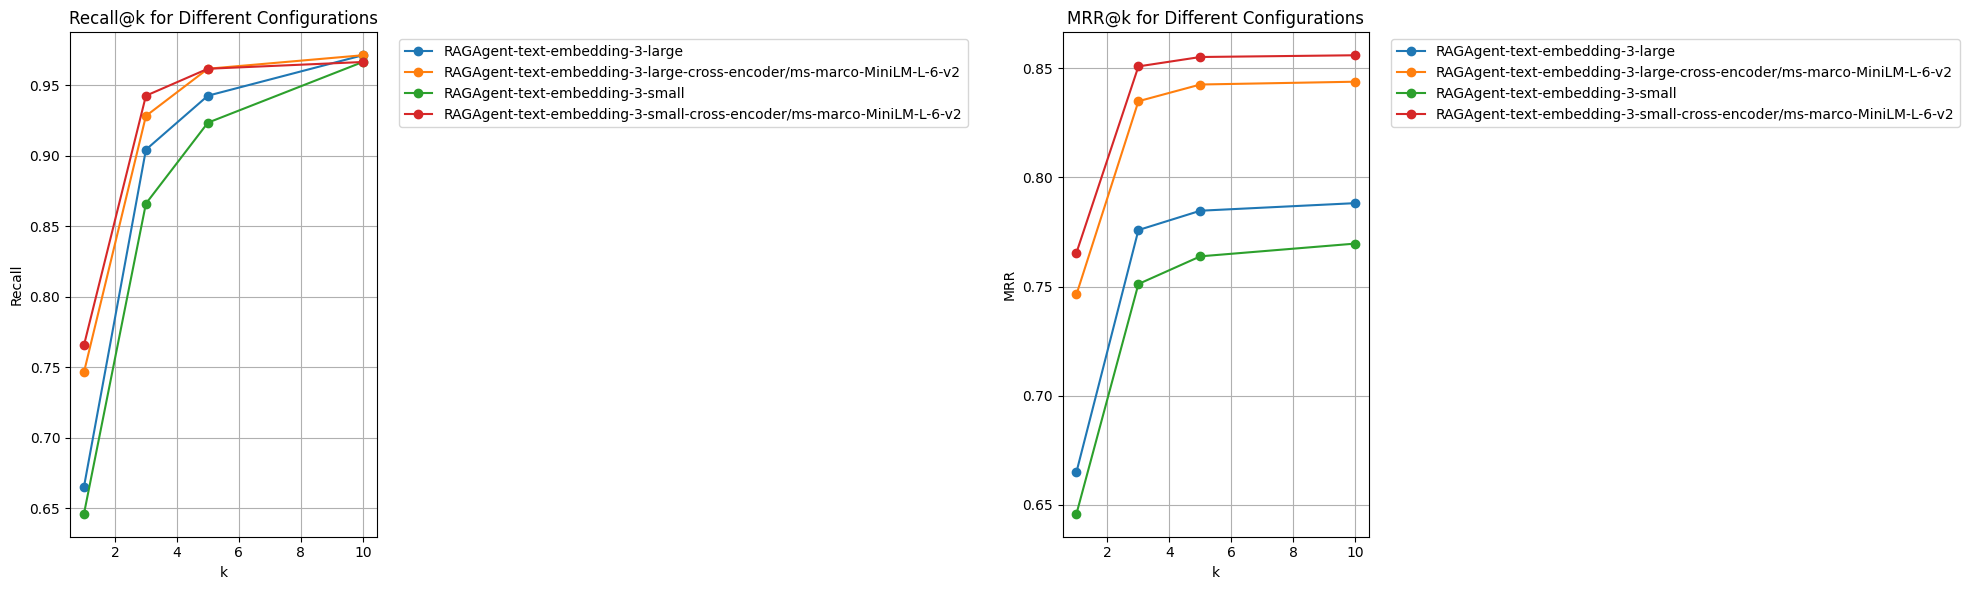

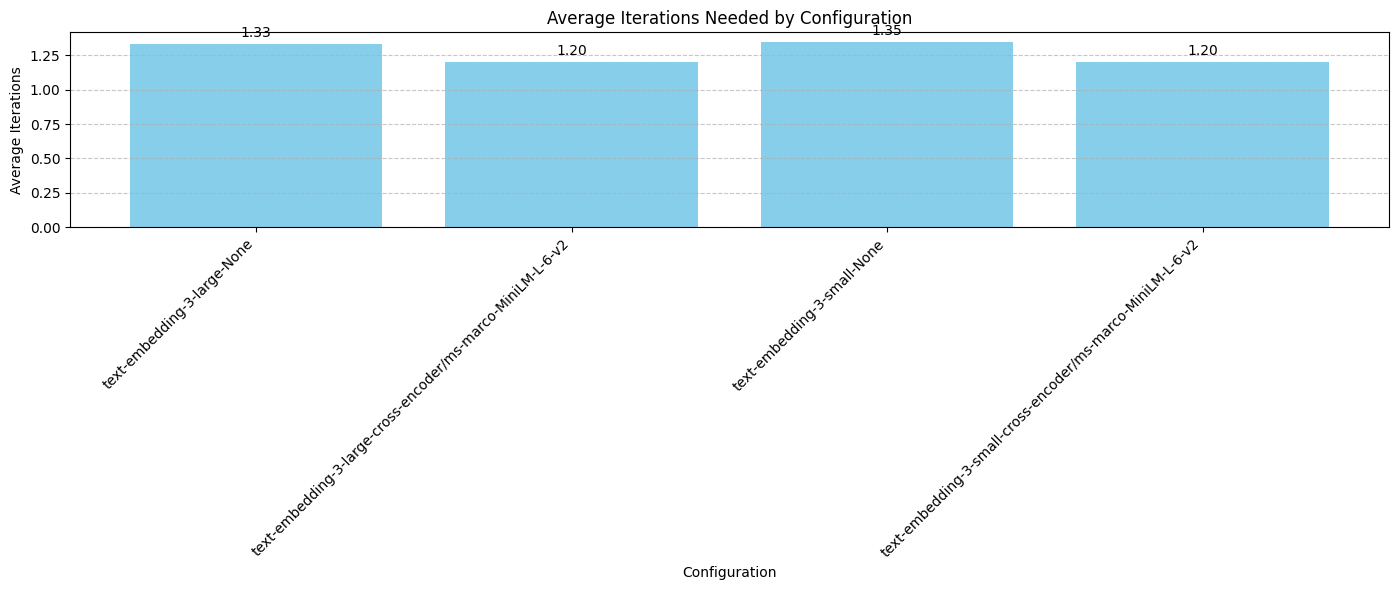

In [84]:
# Initialize evaluator
evaluator = RAGEvaluator(chroma_client)
    
# Create configs to evaluate
configs = [
    evaluator.create_agent_config(
        RAGAgent,
        embedding_model="text-embedding-3-small",
        reranker_model=None,
        llm_model="gpt-3.5-turbo"
    ),
    evaluator.create_agent_config(
        RAGAgent,
        embedding_model="text-embedding-3-large",
        reranker_model=None,
        llm_model="gpt-3.5-turbo"
    ),
    evaluator.create_agent_config(
        RAGAgent,
        embedding_model="text-embedding-3-large",
        reranker_model="cross-encoder/ms-marco-MiniLM-L-6-v2",
        llm_model="gpt-3.5-turbo"
    ), 
    evaluator.create_agent_config(
        RAGAgent,
        embedding_model="text-embedding-3-small",
        reranker_model="cross-encoder/ms-marco-MiniLM-L-6-v2",
        llm_model="gpt-3.5-turbo"
    )
]

evaluation_df = evaluator.evaluate_configurations(eval_df, configs)
evaluator.visualize_results(evaluation_df)
